In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer 
from nltk.probability import FreqDist
import re
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, plot_confusion_matrix, plot_roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

In [2]:
df = pd.read_csv('../data/judge-1377884607_tweet_product_company.csv', encoding= 'unicode_escape')

In [3]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
df.emotion_in_tweet_is_directed_at.value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [5]:
df.isna().sum()

tweet_text                                               1
emotion_in_tweet_is_directed_at                       5802
is_there_an_emotion_directed_at_a_brand_or_product       0
dtype: int64

In [6]:
df.is_there_an_emotion_directed_at_a_brand_or_product.value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [7]:
# rename columns for my sanity 
df.rename(columns={'tweet_text': 'text', 'emotion_in_tweet_is_directed_at': 'product', 
                   'is_there_an_emotion_directed_at_a_brand_or_product': 'sentiment'}, inplace=True)

# clean sentiment value names
sentiment_replace = {'Positive emotion': 'positive', 'Negative emotion': 'negative'}
df.sentiment.replace(sentiment_replace, inplace=True)

For now we'll work on just the positive and negative sentiment since a binary classifier is always easier.
Later We can see if we can classify neutral emotions as well.

In [8]:
df1 = df[(df.sentiment == 'positive') | 
         (df.sentiment == 'negative') ]

In [9]:
df1.sentiment.value_counts(normalize=True)

positive    0.839346
negative    0.160654
Name: sentiment, dtype: float64

The classes are very imbalanced so we'll have to 

In [10]:
df1.isna().sum()

text           0
product      357
sentiment      0
dtype: int64

In [11]:
df['product'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: product, dtype: int64

We have some nulls in the product column. We probably won't make much use of that information anyway, so we'll drop that column and get back to it later.

In [12]:
corpus = df1.drop('product', axis=1)

Because we are trying to filter out the negative tweets, we want to say that the negative tweets are 1 and positive tweets are 0.


In [13]:
corpus.sentiment.replace(('negative', 'positive'), (1, 0), inplace=True)
corpus.sentiment.value_counts(normalize=True)

0    0.839346
1    0.160654
Name: sentiment, dtype: float64

Now that we have the data we need, we can start working on pre-processing the tweets so we can eventually run it through a model.

In [14]:
X = corpus.text
y = corpus.sentiment

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.25)

In [16]:
cv = CountVectorizer()
cv_X_train = cv.fit_transform(X_train)
cv_X_test = cv.transform(X_test)

In [17]:
df_cv = pd.DataFrame(cv_X_train.toarray(), columns=cv.get_feature_names())

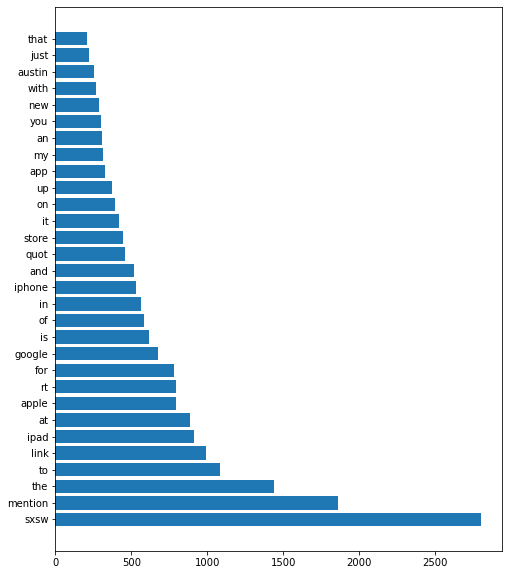

In [18]:
plt.figure(figsize=(8,10))
plt.barh(df_cv.sum().sort_values(ascending=False)[:30].index, df_cv.sum().sort_values(ascending=False)[:30]);

You can see that many of these words are what we call stop-words. Words like "the", "to", "at", "for", these words will not help the machine learn what the sentiment of the tweet is since these words are used in any sentence no matter the context.

We can remove all the stopwords from our CountVectorizer and keep only the more important words.

In [19]:
sw = stopwords.words('english')

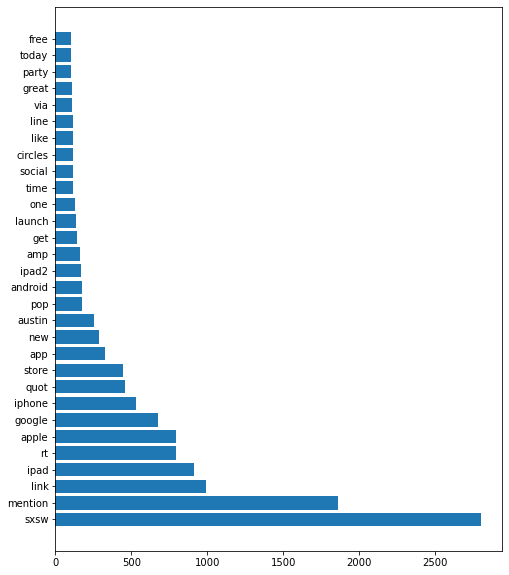

In [20]:
sw_cv = CountVectorizer(stop_words=sw)
sw_cv_X_train = sw_cv.fit_transform(X_train)
sw_cv_X_test = sw_cv.transform(X_test)
sw_df_cv = pd.DataFrame(sw_cv_X_train.toarray(), columns=sw_cv.get_feature_names())
plt.figure(figsize=(8,10))
plt.barh(sw_df_cv.sum().sort_values(ascending=False)[:30].index, sw_df_cv.sum().sort_values(ascending=False)[:30]);

The CountVectorizer from sklearn automatically preprocesses, and tokenizes the words. It is possible that preprocessing on our own will have some different results. Let's try using our own Lemmatizer and our own pattern for the Tokenizer and compare the results.

In [21]:
# This function the correct Part of Speech so the Lemmatizer in the next function can be more accurate.


def get_wordnet_pos(treebank_tag):
    '''
    Translate nltk POS to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [22]:
def tweet_prep(tweet, stop_words=sw):
    '''
    
    :param tweet: a single tweet from thecorpus 
    :return: a tweet string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    tweet = regex_token.tokenize(tweet)
    tweet = [word.lower() for word in tweet]
    tweet = [word for word in tweet if word not in sw]
    tweet = pos_tag(tweet)
    tweet = [(word[0], get_wordnet_pos(word[1])) for word in tweet]
    lemmatizer = WordNetLemmatizer() 
    tweet = [lemmatizer.lemmatize(word[0], word[1]) for word in tweet]
    return ' '.join(tweet)

In [23]:
token_tweets = [tweet_prep(tweet, sw) for tweet in X_train]

In [24]:
X_train_vec = cv.fit_transform(token_tweets)
X_test_vec = cv.transform(X_test)

In [25]:
df_cv = pd.DataFrame(X_train_vec.toarray(), columns=cv.get_feature_names())

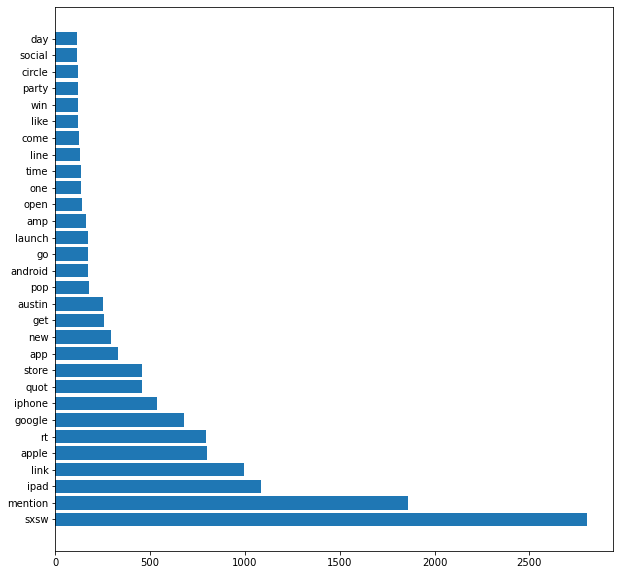

In [26]:
plt.figure(figsize=(10,10))
plt.barh(df_cv.sum().sort_values(ascending=False)[:30].index, df_cv.sum().sort_values(ascending=False)[:30]);

You can see that the most common words are mostly the same, using the default from the CountVectorizer, so we belive it's safe to go with the default.

## Modeling

### Dummy model

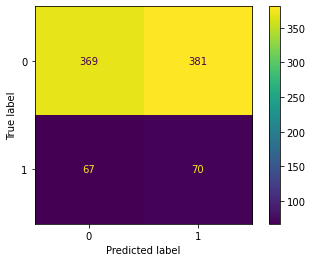

In [27]:
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy='uniform', random_state=42)
dummy.fit(X_train_vec, y_train)
y_pred_dummy_sm = dummy.predict(X_test_vec)
plot_confusion_matrix(estimator=dummy, X=X_test_vec, y_true=y_test);

Our dummy model blindly predicts half positive half negative. So it has about 50% accuarcy.

We can work our way up from there.

We know that getting a high accuracy will not be difficult because of the class imbalance which we noted earlier. The model will take in to acount the priors of each class and lean heavily towards positive classification. But it won't be able to identify the negative tweets very well. We can fix this by adjusting the priors of the algorithm. We'll run a grid search that will find the priors get us the best recall score.

In [28]:
def mnb(X_train, X_test, y_train, y_test, cv=5):
    
    # Set GridSearchCV hyperparameters to compare & select
    grid = {'class_prior': [[0.5,0.5],[0.45,0.55],[0.4,0.6],[0.35,0.65], [0.3,0.7],[0.25,0.75]]}
    
    # Instantiate MultinomialNB model 
    mnb = MultinomialNB()
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=mnb, param_grid=grid, cv=cv, scoring='recall')
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    print(f'Best parameters: {gs.best_params_}')
    
    # Create prediction variable using test data
    y_pred = gs.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(gs, X_train, y_train, cv=cv)
    print(f'Cross-Val Score: {cv_results.mean()}')
    
    # Run and print accuracy, recall, precision and f1 scores
    score = gs.score(X_test, y_test)
    print(f'Test f1: {score}')
    recall = recall_score(y_test, y_pred)
    print(f'Recall Score: {recall}')
    accuarcy = accuracy_score(y_test, y_pred)
    print(f'Accuracy score Score: {accuarcy}')
    precision = precision_score(y_test, y_pred)
    print(f'Precision score: {precision}')
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plot_roc_curve(gs, X_train, y_train, name='train', ax=ax)
    plot_roc_curve(gs, X_test, y_test, name='test', ax=ax)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(gs, X_test, y_test)

Best parameters: {'class_prior': [0.25, 0.75]}
Cross-Val Score: 0.6698209035017375
Test f1: 0.6058394160583942
Recall Score: 0.6058394160583942
Accuracy score Score: 0.8117249154453213
Precision score: 0.42346938775510207


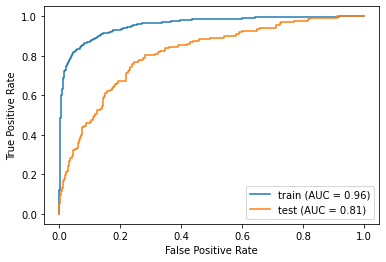

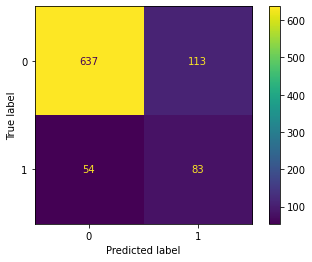

In [29]:
mnb(X_train_vec, X_test_vec, y_train, y_test)

Even with adusting the priors we aren't able to get great recall scores. Another thing we can do to help class imbalance is to use SMOTE. This can produce duplicates of the minority class to even out the classes.

In [30]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='auto',random_state=42)
X_train_sm, y_train_sm = smote.fit_sample(X_train_vec, y_train) 

In [31]:
y_train_sm.value_counts()

1    2228
0    2228
Name: sentiment, dtype: int64

Now that the tweets are balanced, let's see how our model will do.

Best parameters: {'class_prior': [0.25, 0.75]}
Cross-Val Score: 0.9067183957273139
Test f1: 0.6934306569343066
Recall Score: 0.6934306569343066
Accuracy score Score: 0.7305524239007892
Precision score: 0.3253424657534247


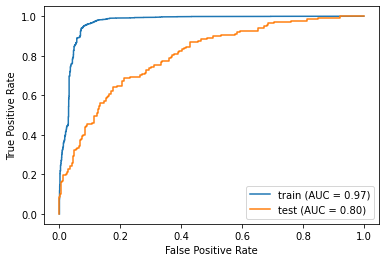

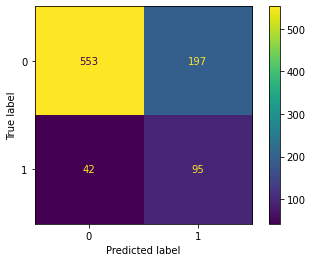

In [32]:
mnb(X_train_sm, X_test_vec, y_train_sm, y_test)

We see that our accuracy went down, but now we are much better at identifying the negative tweets. 
We can try a more sophisticated vectorizer, and also try using different classifying algorithms.

In [38]:
tfidf = TfidfVectorizer()
tfidf_X_train = tfidf.fit_transform(X_train)
tfidf_X_test = tfidf.transform(X_test)
smote2 = SMOTE(sampling_strategy='auto',random_state=42)
X_train_sm2, y_train_sm2 = smote.fit_sample(tfidf_X_train, y_train) 

Best parameters: {'class_prior': [0.25, 0.75]}
Cross-Val Score: 0.9986537008112057
Test f1: 0.9635036496350365
Recall Score: 0.9635036496350365
Accuracy score Score: 0.5704622322435174
Precision score: 0.25984251968503935


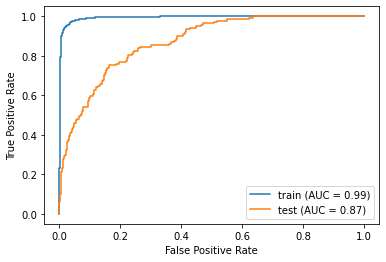

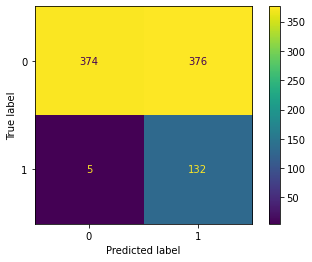

In [39]:
mnb(X_train_sm2, tfidf_X_test, y_train_sm2, y_test)

With the TFIDF Vectorizer we were able to get even better on the negatives. Now we can try some other classifiers.

In [40]:
def random_forest(X_train, X_test, y_train, y_test):
    
    # The number of features to consider when looking for the best split
    n_estimators = [65, 75, 85]
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Create the random grid
    grid = {'n_estimators': n_estimators,
                'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}
    
    # Instantiate random forest classifier 
    rf = RandomForestClassifier()
    
    # Instantiate & fit GridSearchCV with accuracy scoring
    gs = GridSearchCV(estimator=rf, param_grid=grid, cv=5, scoring='recall')
    gs.fit(X_train, y_train)
    
    # Return best hyperparameters
    print(f'Best parameters: {gs.best_params_}')
    
    # Create prediction variable using test data
    y_pred = gs.predict(X_test)
    
    # Run cross-validate score with cv folds from function parameter
    cv_results = cross_val_score(gs, X_train, y_train, cv=5)
    print(f'Cross-Val Score: {cv_results.mean()}')
    
    # Run and print accuracy, recall, precision and f1 scores
    score = gs.score(X_test, y_test)
    print(f'Test f1: {score}')
    recall = recall_score(y_test, y_pred)
    print(f'Recall Score: {recall}')
    accuarcy = accuracy_score(y_test, y_pred)
    print(f'Accuracy score Score: {accuarcy}')
    precision = precision_score(y_test, y_pred)
    print(f'Precision score: {precision}')
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plot_roc_curve(gs, X_train, y_train, name='train', ax=ax)
    plot_roc_curve(gs, X_test, y_test, name='test', ax=ax)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(gs, X_test, y_test)

Best parameters: {'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 85}
Cross-Val Score: 0.9188290421726204
Test f1: 0.7007299270072993
Recall Score: 0.7007299270072993
Accuracy score Score: 0.7497181510710259
Precision score: 0.34657039711191334
Execution time = 612.894318 seconds


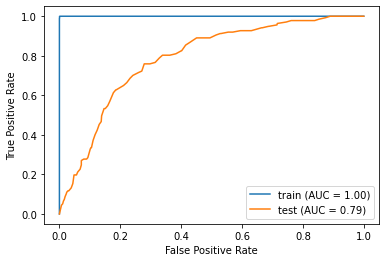

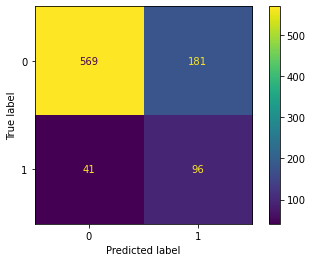

In [41]:
import time
start = time.time()
random_forest(X_train_sm, X_test_vec, y_train_sm, y_test)
end = time.time()
print('Execution time = %.6f seconds' % (end-start))

Best parameters: {'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 65}
Cross-Val Score: 0.9233143548143297
Test f1: 0.3284671532846715
Recall Score: 0.3284671532846715
Accuracy score Score: 0.887260428410372
Precision score: 0.8490566037735849


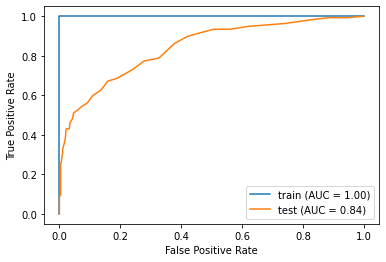

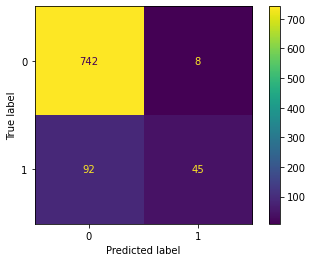

In [42]:
random_forest(X_train_sm2, tfidf_X_test, y_train_sm2, y_test)